# 제품 이상여부 판별 프로젝트

## 1. 데이터 불러오기

### 필수 라이브러리

In [3]:
!pip install tqdm

     ---------------------------------------- 57.6/57.6 kB 3.2 MB/s eta 0:00:00
   ---------------------------------------- 78.4/78.4 kB 4.5 MB/s eta 0:00:00


In [21]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [49]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

### 엑셀 파일을 읽는 함수

읽어오는 속도가 느린 엑셀 파일을 위해 csv 파일로 변환하여 저장해 두고 사용합니다.

In [5]:
def read_excel_file(file_path: str, header: int = None) -> pd.DataFrame:
    csv_file = file_path.replace(".xlsx", ".csv")

    if not os.path.exists(csv_file):
        print("Converting excel to csv...")
        if header:
            df = pd.read_excel(file_path, header=header)
        else:
            df = pd.read_excel(file_path)

        df.to_csv(csv_file, index=False)
        print(f"  {file_path} -> {csv_file}")
        return df
    else:
        print(f"  Reading {csv_file}")
        return pd.read_csv(csv_file, low_memory=False)

In [14]:
os.getcwd()

'c:\\lgaimers'

### 엑셀 파일들 읽어오기

In [11]:
# 얘네는 왜인지 모르겠는데 안 됨

ROOT_DIR = "C://lgaimers"
RANDOM_STATE = 110

X_Dam = read_excel_file(os.path.join(ROOT_DIR, "Dam dispensing.xlsx"), header=1)

X_AutoClave = read_excel_file(
    os.path.join(ROOT_DIR, "Auto clave.xlsx"), header=1
)

X_Fill1 = read_excel_file(
    os.path.join(ROOT_DIR, "Fill1 dispensing.xlsx"), header=1
)

X_Fill2 = read_excel_file(
    os.path.join(ROOT_DIR, "Fill2 dispensing.xlsx"), header=1
)

y = pd.read_csv(os.path.join(ROOT_DIR, "train_y.csv"))

Converting excel to csv...


ImportError: Missing optional dependency 'fsspec'.  Use pip or conda to install fsspec.

In [12]:
# 얘네로 ㄱㄱ

ROOT_DIR = "C:\\lgaimers"
RANDOM_STATE = 110

# 각 엑셀 파일을 읽기
X_Dam = pd.read_excel(os.path.join(ROOT_DIR, "Dam dispensing.xlsx"), header=1)
X_Fill1 = pd.read_excel(os.path.join(ROOT_DIR, "Fill1 dispensing.xlsx"), header=1)
X_Fill2 = pd.read_excel(os.path.join(ROOT_DIR, "Fill2 dispensing.xlsx"), header=1)
X_AutoClave = pd.read_excel(os.path.join(ROOT_DIR, "Auto clave.xlsx"), header=1)

# CSV 파일을 읽기
y = pd.read_csv(os.path.join(ROOT_DIR, "train_y.csv"))

### 데이터 병합

x 데이터 병합

In [15]:
# Rename columns
X_Dam.columns = [i + " - Dam" for i in X_Dam.columns]
X_Fill1.columns = [i + " - Fill1" for i in X_Fill1.columns]
X_Fill2.columns = [i + " - Fill2" for i in X_Fill2.columns]
X_AutoClave.columns = [i + " - AutoClave" for i in X_AutoClave.columns]

X_Dam = X_Dam.rename(columns={"Set ID - Dam": "Set ID"})
X_Fill1 = X_Fill1.rename(columns={"Set ID - Fill1": "Set ID"})
X_Fill2 = X_Fill2.rename(columns={"Set ID - Fill2": "Set ID"})
X_AutoClave = X_AutoClave.rename(columns={"Set ID - AutoClave": "Set ID"})

# Merge X
X = pd.merge(X_Dam, X_Fill1, on="Set ID")
X = pd.merge(X, X_Fill2, on="Set ID")
X = pd.merge(X, X_AutoClave, on="Set ID")

X = X.drop(X[X.duplicated(subset="Set ID")].index).reset_index(drop=True)
X

,Wip Line - Dam,Process Desc. - Dam,Equipment - Dam,Model.Suffix - Dam,Workorder - Dam,LOT ID - Dam,Set ID,Box ID - Dam,Collect Date - Dam,Insp. Seq No. - Dam,...,Collect Result.37 - Fill2,Unit Time.37 - Fill2,Judge Value.37 - Fill2,Collect Result.38 - Fill2,Unit Time.38 - Fill2,Judge Value.38 - Fill2,Collect Result.39 - Fill2,Unit Time.39 - Fill2,Judge Value.39 - Fill2,Unnamed: 131 - Fill2
0,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000002,OP753345013050000002,NaN,2023-05-04 08:57:23,1,...,1,NaN,NaN,1,NaN,NaN,0,NaN,NaN,NaN
1,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000003,OP753345013050000003,NaN,2023-05-04 09:11:35,1,...,2,NaN,NaN,1,NaN,NaN,0,NaN,NaN,NaN
2,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000004,OP753345013050000004,NaN,2023-05-04 09:13:19,1,...,3,NaN,NaN,1,NaN,NaN,0,NaN,NaN,NaN
3,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000005,OP753345013050000005,NaN,2023-05-04 09:15:24,1,...,4,NaN,NaN,1,NaN,NaN,0,NaN,NaN,NaN
4,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000006,OP753345013050000006,NaN,2023-05-04 09:17:27,1,...,5,NaN,NaN,1,NaN,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57862,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334505,4F1XB738-1,OP753345054040002685,OP753345054040002685,NaN,2024-04-28 18:30:42,1,...,11,NaN,NaN,435,NaN,NaN,1,NaN,NaN,0.0
57863,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XB738-1,OP753345054040002686,OP753345054040002686,NaN,2024-04-28 18:31:43,1,...,5,NaN,NaN,436,NaN,NaN,1,NaN,NaN,0.0
57864,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334505,4F1XB738-1,OP753345054040002687,OP753345054040002687,NaN,2024-04-28 18:32:49,1,...,12,NaN,NaN,437,NaN,NaN,1,NaN,NaN,0.0
57865,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XB738-1,OP753345054040002688,OP753345054040002688,NaN,2024-04-28 18:33:51,1,...,6,NaN,NaN,438,NaN,NaN,1,NaN,NaN,0.0


x 데이터와 y 데이터 병합

In [16]:
# Merge X and y
df_merged = pd.merge(X, y, "inner", on="Set ID")

# Drop columns with more than half of the values missing
drop_cols = []
for column in df_merged.columns:
    if (df_merged[column].notnull().sum() // 2) < df_merged[
        column
    ].isnull().sum():
        drop_cols.append(column)
df_merged = df_merged.drop(drop_cols, axis=1)

# Drop Lot ID
df_merged = df_merged.drop("LOT ID - Dam", axis=1)
df_merged

,Wip Line - Dam,Process Desc. - Dam,Equipment - Dam,Model.Suffix - Dam,Workorder - Dam,Set ID,Collect Date - Dam,Insp. Seq No. - Dam,Insp Judge Code - Dam,Collect Result - Dam,...,Collect Result.31 - Fill2,Collect Result.32 - Fill2,Collect Result.33 - Fill2,Collect Result.34 - Fill2,Collect Result.35 - Fill2,Collect Result.36 - Fill2,Collect Result.37 - Fill2,Collect Result.38 - Fill2,Collect Result.39 - Fill2,target
0,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000003,2023-05-04 09:11:35,1,OK,240.0,...,91.8,270.0,50,85,18.200,5.0,2,1,0,AbNormal
1,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000004,2023-05-04 09:13:19,1,OK,240.0,...,91.8,270.0,50,85,18.400,6.0,3,1,0,AbNormal
2,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000007,2023-05-04 09:19:31,1,OK,240.0,...,91.8,270.0,50,85,18.600,1.0,6,1,0,AbNormal
3,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000011,2023-05-04 11:19:55,1,OK,240.0,...,91.8,270.0,50,85,18.200,4.0,18,1,0,AbNormal
4,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000024,2023-05-05 09:35:48,1,OK,240.0,...,91.8,270.0,50,85,18.100,6.0,12,1,0,AbNormal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XB738-1,OP753345054040002680,2024-04-28 18:25:20,1,OK,240.0,...,50.0,91.8,270,50,114.612,18.8,2,430,1,Normal
40502,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334505,4F1XB738-1,OP753345054040002681,2024-04-28 18:26:27,1,OK,1000.0,...,50.0,91.8,270,50,114.612,19.0,9,431,1,Normal
40503,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XB738-1,OP753345054040002682,2024-04-28 18:27:27,1,OK,240.0,...,50.0,91.8,270,50,114.612,19.3,3,432,1,Normal
40504,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XB738-1,OP753345054040002684,2024-04-28 18:29:36,1,OK,240.0,...,50.0,91.8,270,50,114.612,19.6,4,434,1,Normal


In [28]:
# 각 열의 NaN 값 개수 계산
nan_counts = df_merged.isnull().sum()

# NaN 값이 있는 열들만 필터링
nan_columns = nan_counts[nan_counts > 0]

nan_columns

Collect Result.17 - Dam      12766
Collect Result.7 - Fill1     12766
Collect Result.17 - Fill2    12766
dtype: int64

In [35]:
# 각 열의 NaN 값이 있는 행을 표시
nan_dam = df_merged['Collect Result.17 - Dam'].isnull()
nan_fill1 = df_merged['Collect Result.7 - Fill1'].isnull()
nan_fill2 = df_merged['Collect Result.17 - Fill2'].isnull()

# 세 열의 NaN 값이 모두 같은 행에서 발생했는지 확인
nan_same_rows = nan_dam & nan_fill1 & nan_fill2

# NaN 값이 동일한 행의 개수 확인
num_same_nan_rows = nan_same_rows.sum()

# 결과 출력
print(f"세 열에서 NaN 값이 동일한 행의 개수: {num_same_nan_rows}")
print(f"세 열에서 NaN 값이 동일한 행:\n{df_merged[nan_same_rows]}")

세 열에서 NaN 값이 동일한 행의 개수: 12766
세 열에서 NaN 값이 동일한 행:
      Wip Line - Dam Process Desc. - Dam   Equipment - Dam Model.Suffix - Dam  \
16447        IVI-OB6       Dam Dispenser  Dam dispenser #1        AJX75334502   
16448        IVI-OB6       Dam Dispenser  Dam dispenser #2        AJX75334502   
16449        IVI-OB6       Dam Dispenser  Dam dispenser #1        AJX75334502   
16450        IVI-OB6       Dam Dispenser  Dam dispenser #2        AJX75334502   
16451        IVI-OB6       Dam Dispenser  Dam dispenser #1        AJX75334502   
...              ...                 ...               ...                ...   
40501        IVI-OB6       Dam Dispenser  Dam dispenser #1        AJX75334505   
40502        IVI-OB6       Dam Dispenser  Dam dispenser #2        AJX75334505   
40503        IVI-OB6       Dam Dispenser  Dam dispenser #1        AJX75334505   
40504        IVI-OB6       Dam Dispenser  Dam dispenser #1        AJX75334505   
40505        IVI-OB6       Dam Dispenser  Dam dispenser #1 

In [33]:
# 값이 문자열인 열들만 선택
string_columns = df_merged.select_dtypes(include=['object']).columns

string_columns

Index(['Wip Line - Dam', 'Process Desc. - Dam', 'Equipment - Dam',
       'Model.Suffix - Dam', 'Workorder - Dam', 'Set ID',
       'Insp Judge Code - Dam', 'Collect Result.17 - Dam',
       'Wip Line - AutoClave', 'Process Desc. - AutoClave',
       'Equipment - AutoClave', 'Model.Suffix - AutoClave',
       'Workorder - AutoClave', 'LOT ID - AutoClave',
       'Insp Judge Code - AutoClave', 'Judge Value - AutoClave',
       'Judge Value.1 - AutoClave', 'Judge Value.2 - AutoClave',
       'Judge Value.3 - AutoClave', 'Wip Line - Fill1',
       'Process Desc. - Fill1', 'Equipment - Fill1', 'Model.Suffix - Fill1',
       'Workorder - Fill1', 'LOT ID - Fill1', 'Insp Judge Code - Fill1',
       'Collect Result.7 - Fill1', 'Wip Line - Fill2', 'Process Desc. - Fill2',
       'Equipment - Fill2', 'Model.Suffix - Fill2', 'Workorder - Fill2',
       'LOT ID - Fill2', 'Insp Judge Code - Fill2',
       'Collect Result.17 - Fill2', 'target'],
      dtype='object')

In [38]:
# Model.Suffix의 값이 공정에 따라 같은지 다른지 비교할 열 리스트
suffix_columns = [
    'Model.Suffix - Dam',
    'Model.Suffix - Fill1',
    'Model.Suffix - Fill2',
    'Model.Suffix - AutoClave'
]

# 각 행에 대해 모든 비교 열의 값이 동일한지 확인
all_equal = df_merged[suffix_columns].nunique(axis=1) == 1

# 결과 확인
equal_rows = df_merged[all_equal]

# 동일한 값을 가진 행의 개수와 결과 출력
print(f"동일한 값을 가진 행의 개수: {len(equal_rows)}")
print(equal_rows)

동일한 값을 가진 행의 개수: 40506
      Wip Line - Dam Process Desc. - Dam   Equipment - Dam Model.Suffix - Dam  \
0            IVI-OB6       Dam Dispenser  Dam dispenser #1        AJX75334501   
1            IVI-OB6       Dam Dispenser  Dam dispenser #1        AJX75334501   
2            IVI-OB6       Dam Dispenser  Dam dispenser #1        AJX75334501   
3            IVI-OB6       Dam Dispenser  Dam dispenser #1        AJX75334501   
4            IVI-OB6       Dam Dispenser  Dam dispenser #1        AJX75334501   
...              ...                 ...               ...                ...   
40501        IVI-OB6       Dam Dispenser  Dam dispenser #1        AJX75334505   
40502        IVI-OB6       Dam Dispenser  Dam dispenser #2        AJX75334505   
40503        IVI-OB6       Dam Dispenser  Dam dispenser #1        AJX75334505   
40504        IVI-OB6       Dam Dispenser  Dam dispenser #1        AJX75334505   
40505        IVI-OB6       Dam Dispenser  Dam dispenser #1        AJX75334505   

    

In [40]:
# Workorder의 값이 공정에 따라 같은지 다른지 비교할 열 리스트
suffix_columns = [
    'Workorder - Dam',
    'Workorder - Fill1',
    'Workorder - Fill2',
    'Workorder - AutoClave'
]


all_equal = df_merged[suffix_columns].nunique(axis=1) == 1

equal_rows = df_merged[all_equal]

print(f"동일한 값을 가진 행의 개수: {len(equal_rows)}")
print(equal_rows)

동일한 값을 가진 행의 개수: 40506
      Wip Line - Dam Process Desc. - Dam   Equipment - Dam Model.Suffix - Dam  \
0            IVI-OB6       Dam Dispenser  Dam dispenser #1        AJX75334501   
1            IVI-OB6       Dam Dispenser  Dam dispenser #1        AJX75334501   
2            IVI-OB6       Dam Dispenser  Dam dispenser #1        AJX75334501   
3            IVI-OB6       Dam Dispenser  Dam dispenser #1        AJX75334501   
4            IVI-OB6       Dam Dispenser  Dam dispenser #1        AJX75334501   
...              ...                 ...               ...                ...   
40501        IVI-OB6       Dam Dispenser  Dam dispenser #1        AJX75334505   
40502        IVI-OB6       Dam Dispenser  Dam dispenser #2        AJX75334505   
40503        IVI-OB6       Dam Dispenser  Dam dispenser #1        AJX75334505   
40504        IVI-OB6       Dam Dispenser  Dam dispenser #1        AJX75334505   
40505        IVI-OB6       Dam Dispenser  Dam dispenser #1        AJX75334505   

    

In [43]:
# 삭제할 열 리스트
columns_to_drop = [
        'Wip Line - Dam', 'Process Desc. - Dam', 'Insp Judge Code - Dam',
        'Wip Line - Fill1', 'Process Desc. - Fill1', 'LOT ID - Fill1', 'Insp Judge Code - Fill1', 
        'Wip Line - Fill2', 'Process Desc. - Fill2', 'LOT ID - Fill2', 'Insp Judge Code - Fill2', 
        'Wip Line - AutoClave', 'Process Desc. - AutoClave', 'Equipment - AutoClave', 'LOT ID - AutoClave', 'Insp Judge Code - AutoClave',
        'Model.Suffix - Fill1', 'Model.Suffix - Fill2', 'Model.Suffix - AutoClave', 
        'Workorder - Fill1', 'Workorder - Fill2', 'Workorder - AutoClave'
]

# 열 삭제
df_merged = df_merged.drop(columns=columns_to_drop)

# 열 이름 변경
df_merged = df_merged.rename(columns={
    'Model.Suffix - Dam': 'Model.Suffix',
    'Workorder - Dam': 'Workorder'
})

df_merged

,Equipment - Dam,Model.Suffix,Workorder,Set ID,Collect Date - Dam,Insp. Seq No. - Dam,Collect Result - Dam,Collect Result.1 - Dam,Collect Result.2 - Dam,Collect Result.3 - Dam,...,Collect Result.31 - Fill2,Collect Result.32 - Fill2,Collect Result.33 - Fill2,Collect Result.34 - Fill2,Collect Result.35 - Fill2,Collect Result.36 - Fill2,Collect Result.37 - Fill2,Collect Result.38 - Fill2,Collect Result.39 - Fill2,target
0,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000003,2023-05-04 09:11:35,1,240.0,2.5,-90,70,...,91.8,270.0,50,85,18.200,5.0,2,1,0,AbNormal
1,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000004,2023-05-04 09:13:19,1,240.0,2.5,-90,70,...,91.8,270.0,50,85,18.400,6.0,3,1,0,AbNormal
2,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000007,2023-05-04 09:19:31,1,240.0,2.5,-90,70,...,91.8,270.0,50,85,18.600,1.0,6,1,0,AbNormal
3,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000011,2023-05-04 11:19:55,1,240.0,2.5,-90,70,...,91.8,270.0,50,85,18.200,4.0,18,1,0,AbNormal
4,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000024,2023-05-05 09:35:48,1,240.0,2.5,-90,70,...,91.8,270.0,50,85,18.100,6.0,12,1,0,AbNormal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,Dam dispenser #1,AJX75334505,4F1XB738-1,OP753345054040002680,2024-04-28 18:25:20,1,240.0,2.5,-90,100,...,50.0,91.8,270,50,114.612,18.8,2,430,1,Normal
40502,Dam dispenser #2,AJX75334505,4F1XB738-1,OP753345054040002681,2024-04-28 18:26:27,1,1000.0,12.5,90,100,...,50.0,91.8,270,50,114.612,19.0,9,431,1,Normal
40503,Dam dispenser #1,AJX75334505,4F1XB738-1,OP753345054040002682,2024-04-28 18:27:27,1,240.0,2.5,-90,100,...,50.0,91.8,270,50,114.612,19.3,3,432,1,Normal
40504,Dam dispenser #1,AJX75334505,4F1XB738-1,OP753345054040002684,2024-04-28 18:29:36,1,240.0,2.5,-90,100,...,50.0,91.8,270,50,114.612,19.6,4,434,1,Normal


In [29]:
# Collect Date 열 데이터 형식 확인
date_columns = ['Collect Date - Dam', 'Collect Date - AutoClave', 'Collect Date - Fill1', 'Collect Date - Fill2']
data_types = df_merged[date_columns].dtypes

data_types

Collect Date - Dam          datetime64[ns]
Collect Date - AutoClave    datetime64[ns]
Collect Date - Fill1        datetime64[ns]
Collect Date - Fill2        datetime64[ns]
dtype: object


### datetime64[ns] 형식
날짜 관련 연산:
두 날짜 사이의 차이 계산: df['date1'] - df['date2']
특정 날짜 이전 또는 이후의 데이터 필터링: df[df['date'] > '2023-01-01']

날짜 형식 변경:
연도, 월, 일 등 특정 부분 추출: df['date'].dt.year, df['date'].dt.month, df['date'].dt.day

날짜와 시간 조작:
날짜에 특정 기간 더하기 또는 빼기: df['date'] + pd.Timedelta(days=10)

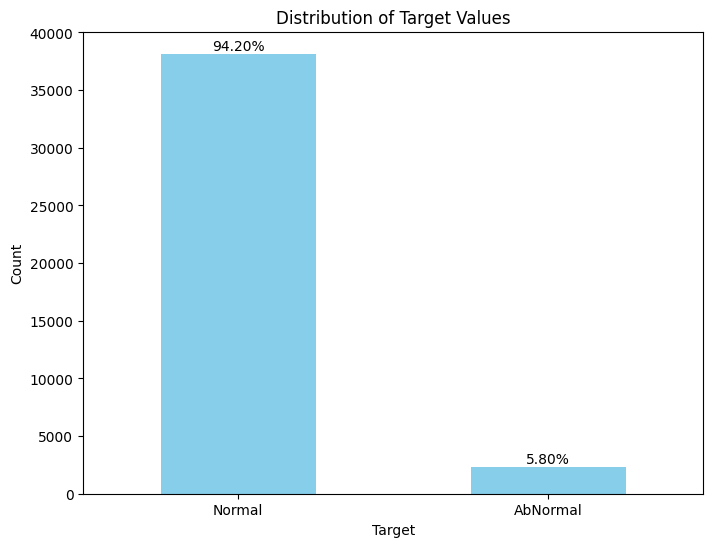

In [36]:
# 'target' 열의 값 세기
target_counts = df_merged['target'].value_counts()

# 'target' 열의 값 비율 계산
target_ratios = df_merged['target'].value_counts(normalize=True)

# 막대그래프 생성
plt.figure(figsize=(8, 6))
target_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Target Values')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks(rotation=0)

# 비율 텍스트 표시
for i, (count, ratio) in enumerate(zip(target_counts, target_ratios)):
    plt.text(i, count + 5, f'{ratio:.2%}', ha='center', va='bottom')

plt.show()

In [44]:
# 'target' 열이 'AbNormal'인 행들만 선택
df_AbNormal = df_merged[df_merged['target'] == 'AbNormal']

df_AbNormal

,Equipment - Dam,Model.Suffix,Workorder,Set ID,Collect Date - Dam,Insp. Seq No. - Dam,Collect Result - Dam,Collect Result.1 - Dam,Collect Result.2 - Dam,Collect Result.3 - Dam,...,Collect Result.31 - Fill2,Collect Result.32 - Fill2,Collect Result.33 - Fill2,Collect Result.34 - Fill2,Collect Result.35 - Fill2,Collect Result.36 - Fill2,Collect Result.37 - Fill2,Collect Result.38 - Fill2,Collect Result.39 - Fill2,target
0,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000003,2023-05-04 09:11:35,1,240.0,2.5,-90,70,...,91.8,270.0,50,85,18.200,5.0,2,1,0,AbNormal
1,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000004,2023-05-04 09:13:19,1,240.0,2.5,-90,70,...,91.8,270.0,50,85,18.400,6.0,3,1,0,AbNormal
2,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000007,2023-05-04 09:19:31,1,240.0,2.5,-90,70,...,91.8,270.0,50,85,18.600,1.0,6,1,0,AbNormal
3,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000011,2023-05-04 11:19:55,1,240.0,2.5,-90,70,...,91.8,270.0,50,85,18.200,4.0,18,1,0,AbNormal
4,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000024,2023-05-05 09:35:48,1,240.0,2.5,-90,70,...,91.8,270.0,50,85,18.100,6.0,12,1,0,AbNormal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40383,Dam dispenser #2,AJX75334505,4F1XB758-1,OP753345054040002333,2024-04-28 14:00:45,1,1000.0,12.5,90,100,...,50.0,91.8,270,50,114.612,20.4,12,236,1,AbNormal
40386,Dam dispenser #1,AJX75334505,4F1XB758-2,OP753345054040002469,2024-04-28 14:08:09,1,240.0,2.5,-90,100,...,50.0,91.8,270,50,114.612,19.7,1,243,1,AbNormal
40387,Dam dispenser #2,AJX75334505,4F1XB758-2,OP753345054040002471,2024-04-28 14:13:30,1,1000.0,12.5,90,100,...,50.0,91.8,270,50,114.612,19.9,10,248,1,AbNormal
40405,Dam dispenser #1,AJX75334505,4F1XB758-1,OP753345054040002359,2024-04-28 14:37:55,1,240.0,2.5,-90,100,...,50.0,91.8,270,50,114.612,19.8,7,271,1,AbNormal


c:\Users\my pc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\my pc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\my pc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\my pc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\clus

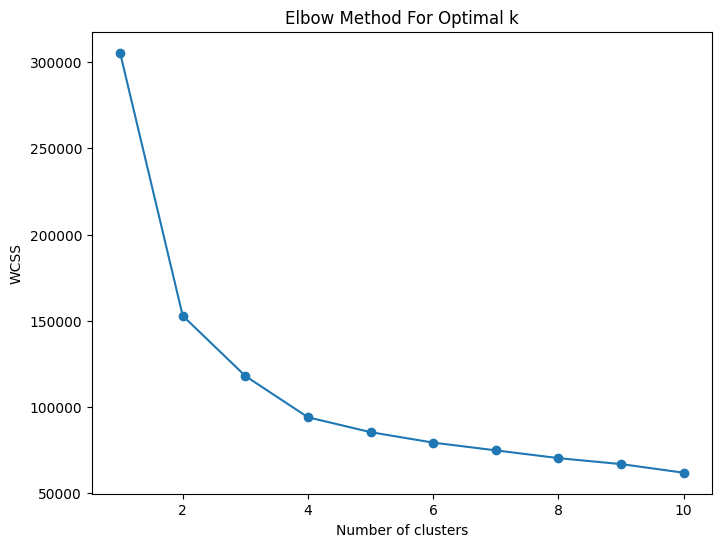

In [46]:
# 문자열 열을 제외한 데이터만 선택
df_AbNormal_numeric = df_AbNormal.select_dtypes(include=[float, int])

# 데이터 전처리
scaler = StandardScaler()
df_AbNormal_scaled = scaler.fit_transform(df_AbNormal_numeric)

# 엘보우 방법을 위한 WCSS 값 계산
wcss = []
for i in range(1, 11):  # 1부터 10까지 클러스터 수를 테스트
    kmeans = KMeans(n_clusters=i, random_state=RANDOM_STATE)
    kmeans.fit(df_AbNormal_scaled)
    wcss.append(kmeans.inertia_)

# 엘보우 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

c:\Users\my pc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\my pc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\my pc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\my pc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\clus

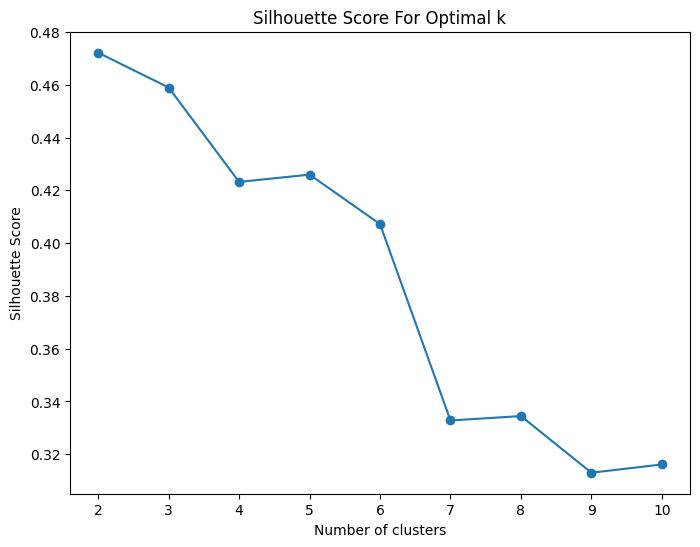

In [47]:
# 문자열 열을 제외한 데이터만 선택
df_AbNormal_numeric = df_AbNormal.select_dtypes(include=[float, int])

# 데이터 전처리
scaler = StandardScaler()
df_AbNormal_scaled = scaler.fit_transform(df_AbNormal_numeric)

# 실루엣 계수를 위한 클러스터 수 테스트
silhouette_scores = []
for i in range(2, 11):  # 2부터 10까지 클러스터 수를 테스트 (1은 군집화가 불가능)
    kmeans = KMeans(n_clusters=i, random_state=RANDOM_STATE)
    cluster_labels = kmeans.fit_predict(df_AbNormal_scaled)
    silhouette_avg = silhouette_score(df_AbNormal_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# 실루엣 계수 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [48]:
# KMeans 군집화 (클러스터 수를 4로 설정)
kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE)
df_AbNormal['Cluster'] = kmeans.fit_predict(df_AbNormal_scaled)

df_AbNormal

c:\Users\my pc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\my pc\AppData\Local\Temp\ipykernel_19960\4001712795.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_AbNormal['Cluster'] = kmeans.fit_predict(df_AbNormal_scaled)


,Equipment - Dam,Model.Suffix,Workorder,Set ID,Collect Date - Dam,Insp. Seq No. - Dam,Collect Result - Dam,Collect Result.1 - Dam,Collect Result.2 - Dam,Collect Result.3 - Dam,...,Collect Result.32 - Fill2,Collect Result.33 - Fill2,Collect Result.34 - Fill2,Collect Result.35 - Fill2,Collect Result.36 - Fill2,Collect Result.37 - Fill2,Collect Result.38 - Fill2,Collect Result.39 - Fill2,target,Cluster
0,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000003,2023-05-04 09:11:35,1,240.0,2.5,-90,70,...,270.0,50,85,18.200,5.0,2,1,0,AbNormal,0
1,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000004,2023-05-04 09:13:19,1,240.0,2.5,-90,70,...,270.0,50,85,18.400,6.0,3,1,0,AbNormal,0
2,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000007,2023-05-04 09:19:31,1,240.0,2.5,-90,70,...,270.0,50,85,18.600,1.0,6,1,0,AbNormal,0
3,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000011,2023-05-04 11:19:55,1,240.0,2.5,-90,70,...,270.0,50,85,18.200,4.0,18,1,0,AbNormal,0
4,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000024,2023-05-05 09:35:48,1,240.0,2.5,-90,70,...,270.0,50,85,18.100,6.0,12,1,0,AbNormal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40383,Dam dispenser #2,AJX75334505,4F1XB758-1,OP753345054040002333,2024-04-28 14:00:45,1,1000.0,12.5,90,100,...,91.8,270,50,114.612,20.4,12,236,1,AbNormal,1
40386,Dam dispenser #1,AJX75334505,4F1XB758-2,OP753345054040002469,2024-04-28 14:08:09,1,240.0,2.5,-90,100,...,91.8,270,50,114.612,19.7,1,243,1,AbNormal,2
40387,Dam dispenser #2,AJX75334505,4F1XB758-2,OP753345054040002471,2024-04-28 14:13:30,1,1000.0,12.5,90,100,...,91.8,270,50,114.612,19.9,10,248,1,AbNormal,1
40405,Dam dispenser #1,AJX75334505,4F1XB758-1,OP753345054040002359,2024-04-28 14:37:55,1,240.0,2.5,-90,100,...,91.8,270,50,114.612,19.8,7,271,1,AbNormal,2


### 언더 샘플링

데이터 불균형을 해결하기 위해 언더 샘플링을 진행합니다.

In [ ]:
normal_ratio = 1.0  # 1.0 means 1:1 ratio

df_normal = df_merged[df_merged["target"] == "Normal"]
df_abnormal = df_merged[df_merged["target"] == "AbNormal"]

num_normal = len(df_normal)
num_abnormal = len(df_abnormal)
print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}")

df_normal = df_normal.sample(
    n=int(num_abnormal * normal_ratio), replace=False, random_state=RANDOM_STATE
)
df_concat = pd.concat([df_normal, df_abnormal], axis=0).reset_index(drop=True)
df_concat.value_counts("target")

### 데이터 분할

In [ ]:
df_concat = df_concat.sort_values(by=["Collect Date - Dam"])
df_train, df_val = train_test_split(
    df_concat,
    test_size=0.3,
    stratify=df_concat["target"],
    random_state=RANDOM_STATE,
)


def print_stats(df: pd.DataFrame):
    num_normal = len(df[df["target"] == "Normal"])
    num_abnormal = len(df[df["target"] == "AbNormal"])

    print(
        f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}"
        + f" ratio: {num_abnormal/num_normal}"
    )


# Print statistics
print(f"  \tAbnormal\tNormal")
print_stats(df_train)
print_stats(df_val)

## 3. 모델 학습

### 모델 정의 

In [ ]:
model = RandomForestClassifier(random_state=RANDOM_STATE)

### 모델 학습

In [ ]:
features = []

for col in df_train.columns:
    try:
        df_train[col] = df_train[col].astype(int)
        features.append(col)
    except:
        continue

if "Set ID" in features:
    features.remove("Set ID")

train_x = df_train[features]
train_y = df_train["target"]

model.fit(train_x, train_y)

## 4. 제출하기

### 테스트 데이터 예측

테스트 데이터 불러오기

In [ ]:
df_test_y = pd.read_csv(os.path.join("submission.csv"))

In [ ]:
df_test = pd.merge(X, df_test_y, "inner", on="Set ID")
df_test_x = df_test[features]

for col in df_test_x.columns:
    try:
        df_test_x.loc[:, col] = df_test_x[col].astype(int)
    except:
        continue

In [ ]:
test_pred = model.predict(df_test_x)
test_pred

### 제출 파일 작성

In [ ]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**